# vLife: Genetic Variant Classification
> <b> Binary classification problem to predict if genetic variant is conflicted or concordant.Build with Robust Random forest classifier solution aims to classify classes for genetic variant whether it is conflicted or concordant.</b>

### Author: Virtusa


### Data Source 
Data for this usecase can be found [here](https://www.kaggle.com/kevinarvai/clinvar-conflicting)
    
    
### Dataset Description
<p> The objective is to predict whether a ClinVar variant will have conflicting classifications. This is presented here as a binary classification problem, where each record in the dataset is a genetic variant.
Conflicting classifications are when two of any of the following three categories are present for one variant, two submissions of one category are not considered conflicting. </p>

* Likely Benign or Benign
* VUS
* Likely Pathogenic or Pathogenic
* Conflicting classification has been assigned to the CLASS column. It is a binary representation of whether or not a variant has conflicting classifications, where 0 represents consistent classifications and 1 represents conflicting classifications.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import operator
from itertools import chain
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold,train_test_split,learning_curve,cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix

Using TensorFlow backend.


# RoadMap

    - Introduction
    - EDA
    - Data Preprocessing
    - Model Building
    - Model Tuning
    - Model Performance

## INTRODUCTION
- Data is from a public resource called ClinVar, which contains annotations about genetic variants. 
- If the variants have conflicting classifications from laboratory to laboratory, it can cause confusion when reserachers try to assess the impact of the variant on a given patient.
- Hence, a classifiication problem to find out if a particular genetic variant is conflicting or concordant.


In [2]:
df= pd.read_csv('clinvar_conflicting.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
pd.set_option('display.max_columns',df.shape[0])

In [4]:
np.set_printoptions(threshold=100)

In [5]:
df.shape

(65188, 46)

In [6]:
df.head()

CHROM     POS REF ALT  AF_ESP  AF_EXAC  AF_TGP  \
0     1  955563   G   C  0.0000  0.00000  0.0000   
1     1  955597   G   T  0.0000  0.42418  0.2826   
2     1  955619   G   C  0.0000  0.03475  0.0088   
3     1  957640   C   T  0.0318  0.02016  0.0328   
4     1  976059   C   T  0.0000  0.00022  0.0010   

                                      CLNDISDB CLNDISDBINCL  \
0  MedGen:C3808739,OMIM:615120|MedGen:CN169374          NaN   
1                              MedGen:CN169374          NaN   
2  MedGen:C3808739,OMIM:615120|MedGen:CN169374          NaN   
3  MedGen:C3808739,OMIM:615120|MedGen:CN169374          NaN   
4                              MedGen:CN169374          NaN   

                                              CLNDN CLNDNINCL  \
0  Myasthenic_syndrome,_congenital,_8|not_specified       NaN   
1                                     not_specified       NaN   
2  Myasthenic_syndrome,_congenital,_8|not_specified       NaN   
3  Myasthenic_syndrome,_congenital,_8|not_specified       NaN   
4                                     not_specified       NaN   

                    CLNHGVS CLNSIGINCL                      CLNVC CLNVI  \
0  NC_000001.10:g.955563G>C        NaN  single_nucleotide_variant   NaN   
1  NC_000001.10:g.955597G>T        NaN  single_nucleotide_variant   NaN   
2  NC_000001.10:g.955619G>C        NaN  single_nucleotide_variant   NaN   
3  NC_000001.10:g.957640C>T        NaN  single_nucleotide_variant   NaN   
4  NC_000001.10:g.976059C>T        NaN  single_nucleotide_variant   NaN   

                              MC  ORIGIN  SSR  CLASS Allele  \
0    SO:0001583|missense_variant     1.0  NaN      0      C   
1  SO:0001819|synonymous_variant     1.0  NaN      0      T   
2    SO:0001583|missense_variant     1.0  NaN      1      C   
3  SO:0001819|synonymous_variant     1.0  NaN      0      T   
4  SO:0001819|synonymous_variant     1.0  NaN      1      T   

          Consequence    IMPACT SYMBOL Feature_type         Feature  \
0    missense_variant  MODERATE   AGRN   Transcript  NM_001305275.1   
1  synonymous_variant       LOW   AGRN   Transcript  NM_001305275.1   
2    missense_variant  MODERATE   AGRN   Transcript  NM_001305275.1   
3  synonymous_variant       LOW   AGRN   Transcript  NM_001305275.1   
4  synonymous_variant       LOW   AGRN   Transcript  NM_001305275.1   

          BIOTYPE  EXON INTRON cDNA_position CDS_position Protein_position  \
0  protein_coding  1/39    NaN            61           11                4   
1  protein_coding  1/39    NaN            95           45               15   
2  protein_coding  1/39    NaN           117           67               23   
3  protein_coding  2/39    NaN           311          261               87   
4  protein_coding  4/39    NaN           576          526              176   

  Amino_acids   Codons  DISTANCE  STRAND BAM_EDIT SIFT PolyPhen MOTIF_NAME  \
0         R/P  cGg/cCg       NaN     1.0      NaN  NaN      NaN        NaN   
1           P  ccG/ccT       NaN     1.0      NaN  NaN      NaN        NaN   
2         V/L  Gtc/Ctc       NaN     1.0      NaN  NaN      NaN        NaN   
3           D  gaC/gaT       NaN     1.0      NaN  NaN      NaN        NaN   
4           L  Ctg/Ttg       NaN     1.0      NaN  NaN      NaN        NaN   

   MOTIF_POS HIGH_INF_POS  MOTIF_SCORE_CHANGE  LoFtool  CADD_PHRED  CADD_RAW  \
0        NaN          NaN                 NaN    0.421      11.390  1.133255   
1        NaN          NaN                 NaN    0.421       8.150  0.599088   
2        NaN          NaN                 NaN    0.421       3.288  0.069819   
3        NaN          NaN                 NaN    0.421      12.560  1.356499   
4        NaN          NaN                 NaN    0.421      17.740  2.234711   

   BLOSUM62  
0      -2.0  
1       NaN  
2       1.0  
3       NaN  
4       NaN

# Exploratory Data Analysis
- Missing Features
- Constant features


In [7]:
%%time
def eda_datatypes(df):
    num_data = df.select_dtypes(include=['int64','float64'])
    print("Numerical features count:", len(num_data.columns))
  #  print(num_data.columns)
    cat_data = df.select_dtypes(include='object')
    print("Object type features count:", len(cat_data.columns))
   # print(cat_data.columns)
    temporal_data = [var for var in num_data if 'Yr' in var or 'Year' in var]
    print("Temporal features count:", len(temporal_data))
    #print(temporal_data)
    
eda_datatypes(df)

Numerical features count: 15
Object type features count: 31
Temporal features count: 0
CPU times: user 48.5 ms, sys: 8.04 ms, total: 56.6 ms
Wall time: 54.3 ms


#### Missing features

In [8]:
desc=df.describe(include='all').T.reset_index()
desc['missing %']=(1-(desc['count']/len(df)))*100
desc

index  count unique                            top   freq  \
0                CHROM  65188     25                              2   8645   
1                  POS  65188    NaN                            NaN    NaN   
2                  REF  65188    866                              C  21798   
3                  ALT  65188    458                              T  20409   
4               AF_ESP  65188    NaN                            NaN    NaN   
5              AF_EXAC  65188    NaN                            NaN    NaN   
6               AF_TGP  65188    NaN                            NaN    NaN   
7             CLNDISDB  65188   9234                MedGen:CN169374   5344   
8         CLNDISDBINCL     76     48                MedGen:CN169374      7   
9                CLNDN  65188   9260                  not_specified   5344   
10           CLNDNINCL     76     54                  not_specified      7   
11             CLNHGVS  65188  65188      NC_000007.13:g.6042173G>A      1   
12          CLNSIGINCL     76     68  157525:Uncertain_significance      2   
13               CLNVC  65188      7      single_nucleotide_variant  61281   
14               CLNVI  27659  26289     UniProtKB_(protein):P04637    124   
15                  MC  58219     89    SO:0001583|missense_variant  23034   
16              ORIGIN  59065    NaN                            NaN    NaN   
17                 SSR    104    NaN                            NaN    NaN   
18               CLASS  65188    NaN                            NaN    NaN   
19              Allele  65188    374                              T  19991   
20         Consequence  65188     48               missense_variant  31444   
21              IMPACT  65188      4                       MODERATE  33212   
22              SYMBOL  65172   2328                            TTN   2765   
23        Feature_type  65174      2                     Transcript  65172   
24             Feature  65174   2369                 NM_001267550.1   2765   
25             BIOTYPE  65172      2                 protein_coding  65158   
26                EXON  56295   3264                          16/16   1129   
27              INTRON   8803   1929                         47/362     93   
28       cDNA_position  56304  13970                            852     31   
29        CDS_position  55233  13663                              1     36   
30    Protein_position  55233   7339                              1    100   
31         Amino_acids  55184   1262                              A   2005   
32              Codons  55184   2220                        cGg/cAg    915   
33            DISTANCE    108    NaN                            NaN    NaN   
34              STRAND  65174    NaN                            NaN    NaN   
35            BAM_EDIT  31969      2                             OK  31707   
36                SIFT  24836      4                    deleterious  11500   
37            PolyPhen  24796      4                         benign  13329   
38          MOTIF_NAME      2      2                 FOXA1:MA0546.1      1   
39           MOTIF_POS      2    NaN                            NaN    NaN   
40        HIGH_INF_POS      2      1                              N      2   
41  MOTIF_SCORE_CHANGE      2    NaN                            NaN    NaN   
42             LoFtool  60975    NaN                            NaN    NaN   
43          CADD_PHRED  64096    NaN                            NaN    NaN   
44            CADD_RAW  64096    NaN                            NaN    NaN   
45            BLOSUM62  25593    NaN                            NaN    NaN   

           mean          std       min          25%          50%          75%  \
0           NaN          NaN       NaN          NaN          NaN          NaN   
1   7.75759e+07  5.97405e+07       961  3.25418e+07  5.79702e+07  1.12745e+08   
2           NaN          NaN       NaN          NaN          NaN          NaN   
3           NaN          N

##### Conclusion: Need to drop >50% sparse cols during data preprocessing

In [9]:
to_drop = list(desc[desc['missing %']>50]['index'])
len(to_drop)

15

#### Constant Variables 
Constant features are those that show the same value, just one value, for all the observations of the dataset. These features provide no information that allows a machine learning model to discriminate or predict a target.

- Numerical Constant Features

In [10]:
constant_features = [
    feat for feat in df.select_dtypes('float64').columns if df[feat].std() == 0
]
print('Number of constant numerical features: ', len(constant_features))
print('Feature Names:',constant_features)

Number of constant numerical features:  1
Feature Names: ['MOTIF_POS']


- Categorical Constant Features

In [11]:
# Finding categorical features that are constant
constant_features = [
    feat for feat in df.columns if len(df[feat].unique()) == 1
]
print('Number of constant categorical features: ', len(constant_features))
print('Feature Names:',constant_features)

Number of constant categorical features:  0
Feature Names: []


#### Quasi-constant features 
Those that show the same value for the great majority of the observations of the dataset. In general, these features provide little if any information that allows a machine learning model to discriminate or predict a target. But as with everything in life, there are always exceptions.

In [12]:
quasi_constant_feat = []
for feature in df.columns:

    # Find the predominant value
    predominant = (df[feature].value_counts() / np.float(
        len(df))).sort_values(ascending=False).values[0]

    # Evaluate predominant feature
    if predominant > 0.998:
        quasi_constant_feat.append(feature)

print('Number of quasi-constant features: ', len(quasi_constant_feat))
print('Feature Names:',quasi_constant_feat)

Number of quasi-constant features:  2
Feature Names: ['Feature_type', 'BIOTYPE']


##### Conclusion: Need to drop all constant features

#### Insight: (CLASS vs Number of variants) 
The CLASS distribution is skewed a bit to the 0 class, meaning there are fewer variants with conflicting submissions.

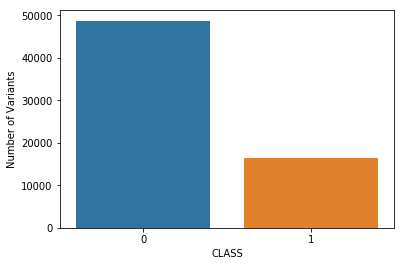

In [13]:
ax = sns.countplot(x="CLASS", data=df)
ax.set(xlabel='CLASS', ylabel='Number of Variants');

#### Insight: (REF vs ALT)
C→T and G→A SNPs are the most prominent in this dataset

In [12]:
df['REF'].value_counts().head(5)

C     21798
G     21361
A      9845
T      9421
CT      126
Name: REF, dtype: int64

In [13]:
df['ALT'].value_counts().head(5)

T     20409
A     20205
G     11782
C     11429
TA      118
Name: ALT, dtype: int64

In [14]:
(df[['REF', 'ALT']].apply(lambda x: ':'.join(x), axis=1)).value_counts().head()

C:T    16214
G:A    16033
A:G     6905
T:C     6482
C:G     2912
dtype: int64

#### Insight: (Distribution of Allele Frequency)
Most are in range of 0s

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f512cc6e198>,
      dtype=object)

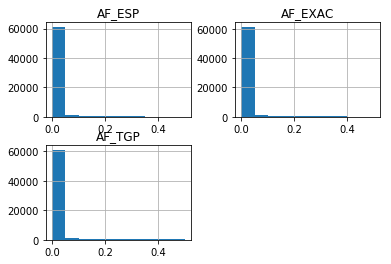

In [15]:
df[['AF_ESP', 'AF_EXAC', 'AF_TGP']].hist()

#### ORIGIN 

In [20]:
print(Counter(df['ORIGIN'].values))

Counter({1.0: 58216, 33.0: 246, 5.0: 149, 3.0: 142, 17.0: 139, 9.0: 100, 0.0: 13, 25.0: 11, 32.0: 10, 49.0: 7, 513.0: 5, 65.0: 4, 21.0: 3, 2.0: 3, 16.0: 2, 13.0: 2, 4.0: 2, 41.0: 2, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, na

#### Conclusion: Need to fill nan with 0 because according to data description,0 should be the unknown origin, but this doesn't seem to be the case, so fill all nan with 0s while data preprocessing

#### Insight: (IMPACT distribution across classes)

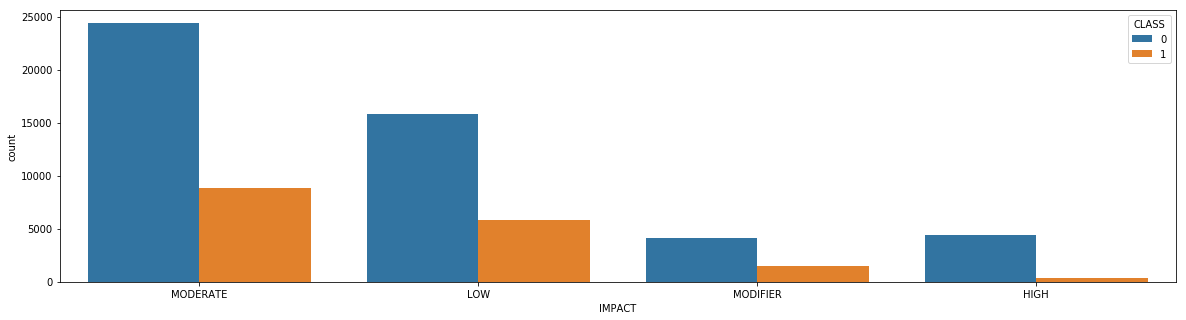

In [21]:
plt.figure(figsize=(20,5))
sns.countplot(x='IMPACT',data=df,hue='CLASS')

In [22]:
Counter(list(chain.from_iterable([str(v).split('&') for v in df['Consequence'].values]))).items()

dict_items([('missense_variant', 32408), ('synonymous_variant', 18220), ('splice_region_variant', 5065), ('intron_variant', 7847), ('3_prime_UTR_variant', 435), ('frameshift_variant', 1864), ('inframe_insertion', 204), ('inframe_deletion', 593), ('stop_lost', 16), ('stop_gained', 1800), ('5_prime_UTR_variant', 642), ('splice_acceptor_variant', 421), ('coding_sequence_variant', 43), ('splice_donor_variant', 584), ('start_lost', 100), ('downstream_gene_variant', 26), ('protein_altering_variant', 10), ('upstream_gene_variant', 82), ('stop_retained_variant', 12), ('non_coding_transcript_variant', 1), ('start_retained_variant', 1), ('TF_binding_site_variant', 2), ('intergenic_variant', 14)])

#### Consequence

In [23]:
cons = Counter(list(chain.from_iterable([str(v).split('&') for v in df['Consequence'].values])))
sorted(cons.items(),key=operator.itemgetter(1),reverse=True)

[('missense_variant', 32408),
 ('synonymous_variant', 18220),
 ('intron_variant', 7847),
 ('splice_region_variant', 5065),
 ('frameshift_variant', 1864),
 ('stop_gained', 1800),
 ('5_prime_UTR_variant', 642),
 ('inframe_deletion', 593),
 ('splice_donor_variant', 584),
 ('3_prime_UTR_variant', 435),
 ('splice_acceptor_variant', 421),
 ('inframe_insertion', 204),
 ('start_lost', 100),
 ('upstream_gene_variant', 82),
 ('coding_sequence_variant', 43),
 ('downstream_gene_variant', 26),
 ('stop_lost', 16),
 ('intergenic_variant', 14),
 ('stop_retained_variant', 12),
 ('protein_altering_variant', 10),
 ('TF_binding_site_variant', 2),
 ('non_coding_transcript_variant', 1),
 ('start_retained_variant', 1)]

#### CLNVC(Variant Type )

In [24]:
clnvc = Counter(df['CLNVC'].values)
sorted(clnvc.items(),key=operator.itemgetter(1),reverse=True)

[('single_nucleotide_variant', 61281),
 ('Deletion', 2509),
 ('Duplication', 1034),
 ('Indel', 247),
 ('Insertion', 95),
 ('Inversion', 17),
 ('Microsatellite', 5)]

##### Conclusion: single_nucleotide_variant(SNP) is the most common variant method across dataset

#### Insight: (CLASS vs CHROM)
As you can observe in the graph given below, the dataset happens to be heavily biased towards the non - conflicting genes and that too with the CHROM == 2 standing out as the clear bias winner.
What to take out from this graph? Since the incidents where the genes are recorded to be conflicting, we can assume that our classifiers won't be doing much of a great job and we can assume that most of them would take CHROM 2 as their most important feature.

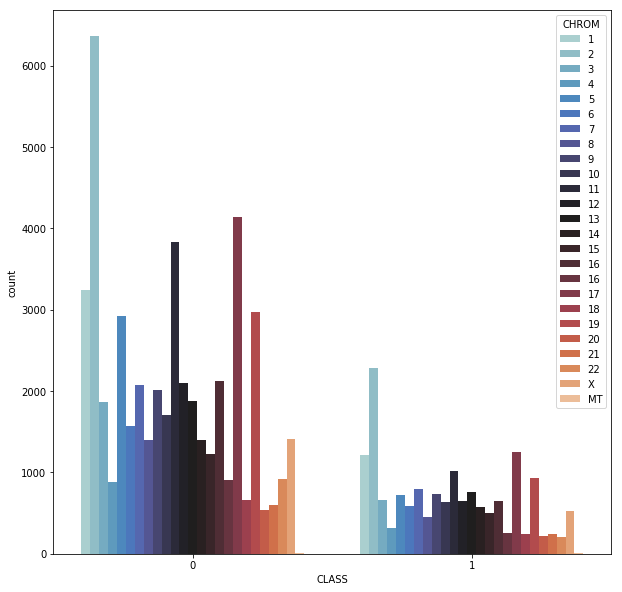

In [25]:
fig = plt.figure(figsize = (10, 10))
sns.countplot(x= 'CLASS', data = df, hue = 'CHROM', palette='icefire')

#### Insight: (CLASS vs SYMBOL)


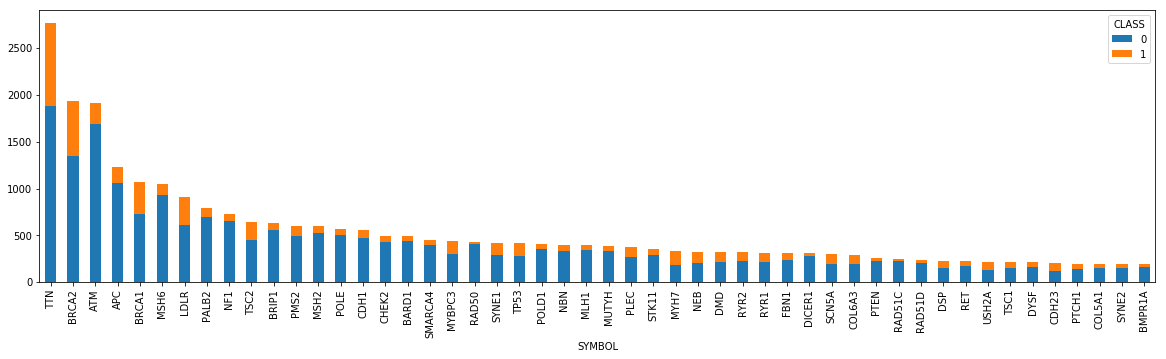

In [26]:
gene_ct = pd.crosstab(df['SYMBOL'], df['CLASS'], margins=True)
gene_ct.drop('All', axis=0, inplace=True)

# Limit to the 50 most submitted genes for visualization
gene_ct = gene_ct.sort_values(by='All', ascending=False).head(50)
gene_ct.drop('All', axis=1, inplace=True)

gene_ct.plot.bar(stacked=True, figsize=(20, 5));

In [27]:
desc=df.describe(include='all').T.reset_index()
desc['missing %']=(1-(desc['count']/len(df)))*100
desc

index  count unique                                     top  \
0                CHROM  65188     25                                       2   
1                  POS  65188    NaN                                     NaN   
2                  REF  65188    866                                       C   
3                  ALT  65188    458                                       T   
4               AF_ESP  65188    NaN                                     NaN   
5              AF_EXAC  65188    NaN                                     NaN   
6               AF_TGP  65188    NaN                                     NaN   
7             CLNDISDB  65188   9234                         MedGen:CN169374   
8         CLNDISDBINCL     76     48                                       .   
9                CLNDN  65188   9260                           not_specified   
10           CLNDNINCL     76     54                           not_specified   
11             CLNHGVS  65188  65188  NC_000009.11:g.75445601_75445603delTGG   
12          CLNSIGINCL     76     68                424791:Likely_pathogenic   
13               CLNVC  65188      7               single_nucleotide_variant   
14               CLNVI  27659  26289              UniProtKB_(protein):P04637   
15                  MC  58219     89             SO:0001583|missense_variant   
16              ORIGIN  59065    NaN                                     NaN   
17                 SSR    104    NaN                                     NaN   
18               CLASS  65188    NaN                                     NaN   
19              Allele  65188    374                                       T   
20         Consequence  65188     48                        missense_variant   
21              IMPACT  65188      4                                MODERATE   
22              SYMBOL  65172   2328                                     TTN   
23        Feature_type  65174      2                              Transcript   
24             Feature  65174   2369                          NM_001267550.1   
25             BIOTYPE  65172      2                          protein_coding   
26                EXON  56295   3264                                   16/16   
27              INTRON   8803   1929                                  47/362   
28       cDNA_position  56304  13970                                     852   
29        CDS_position  55233  13663                                       1   
30    Protein_position  55233   7339                                       1   
31         Amino_acids  55184   1262                                       A   
32              Codons  55184   2220                                 cGg/cAg   
33            DISTANCE    108    NaN                                     NaN   
34              STRAND  65174    NaN                                     NaN   
35            BAM_EDIT  31969      2                                      OK   
36                SIFT  24836      4                             deleterious   
37            PolyPhen  24796      4                                  benign   
38          MOTIF_NAME      2      2                          FOXA1:MA0546.1   
39           MOTIF_POS      2    NaN                                     NaN   
40        HIGH_INF_POS      2      1                                       N   
41  MOTIF_SCORE_CHANGE      2    NaN                                     NaN   
42             LoFtool  60975    NaN                                     NaN   
43          CADD_PHRED  64096    NaN                                     NaN   
44            CADD_RAW  64096    NaN                                     NaN   
45            BLOSUM62  25593    NaN                                     NaN   

     freq         mean          std       min          25%          50%  \
0    8645          NaN          NaN       NaN          NaN          NaN   
1     NaN  7.75759e+07  5.97405e+07       961  3.25418e+07  5.79702e+07   
2   21798          NaN         

#### EXON

- Fill missing values with 0 during data preprocessing
- Need to convert into numerical during data preprocessing

variant_exon = 0 represents that the variant is located in an Intron. Intron variants seem to be conflicting much more frequently than exon variants.

In [13]:
df['EXON'].unique()

array(['1/39', '2/39', '4/39', ..., '38/45', '39/45', '30/53'],
      dtype=object)

In [41]:
a=df.copy()

In [17]:
a.EXON.fillna('0', inplace=True)

In [18]:
a['variant_exon'] = a['EXON'].apply(lambda x: [int(s) for s in re.findall(r'\b\d+\b', x)][0])

(-0.5, 20.5)

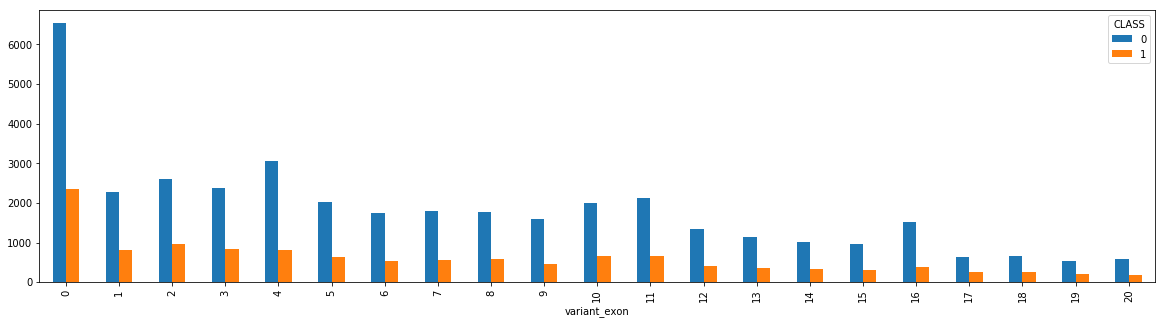

In [21]:
exondf = pd.crosstab(a['variant_exon'], a['CLASS'])
exondf.plot.bar(stacked=False, figsize=(20, 5));
plt.xlim(-0.5, 20.5)

#### INTRON

In [23]:
df['INTRON'].unique()

array([nan, '6/38', '16/38', ..., '32/52', '12/47', '2/47'], dtype=object)

In [24]:
a.INTRON.fillna('0', inplace=True)

In [25]:
a['variant_intron'] = a['INTRON'].apply(lambda x: [int(s) for s in re.findall(r'\b\d+\b', x)][0])

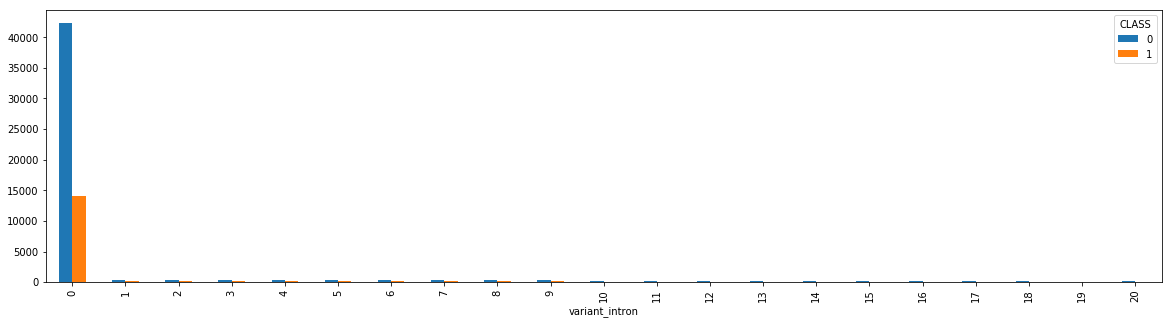

In [26]:
introndf = pd.crosstab(a['variant_intron'], a['CLASS'])
introndf.plot.bar(stacked=False, figsize=(20, 5));
plt.xlim(-0.5, 20.5);

In [29]:
del a

#### cDNA_position
Filling NaN's with 0's and converting to integer.

In [39]:
df['cDNA_position'].unique()

array(['61', '95', '117', ..., '496-500', '1701-1702', '1702-1704'],
      dtype=object)

#### CADD_RAW, CADD_PHRED scores 

In [47]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go #for plotly graphs
dtt = df.head(800).assign(n=0).groupby(['CADD_RAW', 'CADD_PHRED'])['n'].count().reset_index()
dtt = dtt[dtt["CADD_PHRED"] < 2000]
ver = dtt.pivot(index='CADD_PHRED', columns='CADD_RAW', values='n').fillna(0).values.tolist()
iplot([go.Surface(z=ver)])
#plotly Surface (the most impressive feature)
#shows the distribution of CADD_RAW against CADD_PHRED

In [40]:
df['CADD_RAW'].min()

-5.477391000000001

#### Insight: AFTGP  vs POS with respect to CLNDN

-  Immunodeficiency is rare for most allele frequencies AF-TGP(from the 1000 genome project) and positions of variants on chromosome(POS).
- Idiopathic generalised epilepsy is more commonly for all frequencies below 0.05
- Most common disease is nephronophthisis , which commonly occurs for most positions of variants on a chromosome

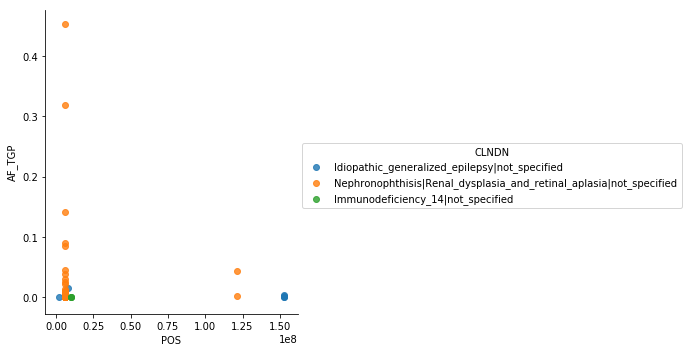

In [48]:
sns.lmplot(x='POS', y='AF_TGP', hue='CLNDN', 
           data=df.loc[df['CLNDN'].isin(['Immunodeficiency_14|not_specified', 'Idiopathic_generalized_epilepsy|not_specified', 'Nephronophthisis|Renal_dysplasia_and_retinal_aplasia|not_specified'])], 
           fit_reg=False)

#### Insight: SNV and Indel Counts
- One of the ways variants can be classified is by the amount (and type) of sequence change.
- SNV(single nucleotide variant) is a substitution of nucleotide(letter), also referred as single nucleotide polymorphisms(SNP) i.e. if length of REF/ALT equals 1.
- Indel is when one or more nucleotides are inserted or deleted i.e. if length of REF/ALT is >1.

#### Conclusion: SNVs more likely to be conflicting than indel

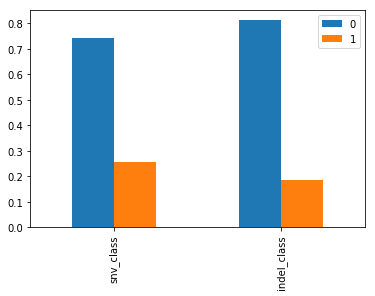

In [50]:
snvs = df.loc[(df.REF.str.len()==1) & (df.ALT.str.len()==1)]
indels = df.loc[(df.REF.str.len()>1) | (df.ALT.str.len()>1)]
snp_indel = pd.concat([snvs.CLASS.value_counts(normalize=True).rename('snv_class'), 
                       indels.CLASS.value_counts(normalize=True).rename('indel_class')], 
                      axis=1).T
snp_indel.plot.bar()

In [44]:
df.shape

(65188, 46)

#### Descriptive table for numerical features

In [51]:
df.describe().T

count          mean           std         min  \
POS                 65188.0  7.757594e+07  5.974051e+07  961.000000   
AF_ESP              65188.0  1.451052e-02  5.779541e-02    0.000000   
AF_EXAC             65188.0  1.449218e-02  5.954210e-02    0.000000   
AF_TGP              65188.0  1.526350e-02  5.952741e-02    0.000000   
ORIGIN              59065.0  1.272869e+00  5.343258e+00    0.000000   
SSR                   104.0  2.298077e+00  4.237786e+00    1.000000   
CLASS               65188.0  2.521016e-01  4.342226e-01    0.000000   
DISTANCE              108.0  8.257315e+02  1.069363e+03    1.000000   
STRAND              65174.0 -6.659097e-03  9.999855e-01   -1.000000   
MOTIF_POS               2.0  1.000000e+00  0.000000e+00    1.000000   
MOTIF_SCORE_CHANGE      2.0 -8.000000e-02  2.404163e-02   -0.097000   
LoFtool             60975.0  3.450584e-01  3.612384e-01    0.000069   
CADD_PHRED          64096.0  1.568562e+01  1.083635e+01    0.001000   
CADD_RAW            64096.0  2.554131e+00  2.961553e+00   -5.477391   
BLOSUM62            25593.0 -4.022584e-01  1.872684e+00   -3.000000   
variant_exon        65188.0  2.103594e+01  5.029745e+01    0.000000   
variant_intron      65188.0  2.594327e+00  1.363638e+01    0.000000   

                             25%           50%           75%           max  
POS                 3.254179e+07  5.797021e+07  1.127454e+08  2.476080e+08  
AF_ESP              0.000000e+00  0.000000e+00  1.200000e-03  4.990000e-01  
AF_EXAC             0.000000e+00  4.000000e-05  1.230000e-03  4.998900e-01  
AF_TGP              0.000000e+00  0.000000e+00  1.600000e-03  4.998000e-01  
ORIGIN              1.000000e+00  1.000000e+00  1.000000e+00  5.130000e+02  
SSR                 1.000000e+00  1.000000e+00  1.000000e+00  1.600000e+01  
CLASS               0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  
DISTANCE            5.550000e+01  4.690000e+02  1.415000e+03  4.759000e+03  
STRAND             -1.000000e+00 -1.000000e+00  1.000000e+00  1.000000e+00  
MOTIF_POS           1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  
MOTIF_SCORE_CHANGE -8.850000e-02 -8.000000e-02 -7.150000e-02 -6.300000e-02  
LoFtool             2.430000e-02  1.570000e-01  7.100000e-01  1.000000e+00  
CADD_PHRED          7.141000e+00  1.409000e+01  2.410000e+01  9.900000e+01  
CADD_RAW            4.629507e-01  1.642948e+00  4.381392e+00  4.655626e+01  
BLOSUM62           -2.000000e+00 -1.000000e+00  1.000000e+00  3.000000e+00  
variant_exon        3.000000e+00  9.000000e+00  1.800000e+01  3.630000e+02  
variant_intron      0.000000e+00  0.000000e+00  0.000000e+00  3.610000e+02

#### Descriptive table for categorical features

In [52]:
df.select_dtypes(include=['object']).describe().T

count unique                                     top   freq
CHROM             65188     25                                       2   8645
REF               65188    866                                       C  21798
ALT               65188    458                                       T  20409
CLNDISDB          65188   9234                         MedGen:CN169374   5344
CLNDISDBINCL         76     48                                       .      7
CLNDN             65188   9260                           not_specified   5344
CLNDNINCL            76     54                           not_specified      7
CLNHGVS           65188  65188  NC_000009.11:g.75445601_75445603delTGG      1
CLNSIGINCL           76     68                424791:Likely_pathogenic      2
CLNVC             65188      7               single_nucleotide_variant  61281
CLNVI             27659  26289              UniProtKB_(protein):P04637    124
MC                58219     89             SO:0001583|missense_variant  23034
Allele            65188    374                                       T  19991
Consequence       65188     48                        missense_variant  31444
IMPACT            65188      4                                MODERATE  33212
SYMBOL            65172   2328                                     TTN   2765
Feature_type      65174      2                              Transcript  65172
Feature           65174   2369                          NM_001267550.1   2765
BIOTYPE           65172      2                          protein_coding  65158
EXON              65188   3265                                       0   8893
INTRON            65188   1930                                       0  56385
cDNA_position     56304  13970                                     852     31
CDS_position      55233  13663                                       1     36
Protein_position  55233   7339                                       1    100
Amino_acids       55184   1262                                       A   2005
Codons            55184   2220                                 cGg/cAg    915
BAM_EDIT          31969      2                                      OK  31707
SIFT              24836      4                             deleterious  11500
PolyPhen          24796      4                                  benign  13329
MOTIF_NAME            2      2                          FOXA1:MA0546.1      1
HIGH_INF_POS          2      1                                       N      2

# Data Preprocessing

### Drop missing features having more than 50% misses

In [13]:
df.shape

(65188, 46)

In [14]:
df=df.drop(to_drop,axis=1)

In [15]:
df.shape

(65188, 31)

### Dropping our constant features

In [16]:
df.drop(labels=constant_features, axis=1, inplace=True)
df.drop(labels=quasi_constant_feat, axis=1, inplace=True)
df.drop(labels=constant_features, axis=1, inplace=True)
df.shape

(65188, 29)

### Categorical Variables

In [17]:
df_cat= df.select_dtypes(include=['object'])
df_cat.head(2)

CHROM REF ALT                                     CLNDISDB  \
0     1   G   C  MedGen:C3808739,OMIM:615120|MedGen:CN169374   
1     1   G   T                              MedGen:CN169374   

                                              CLNDN                   CLNHGVS  \
0  Myasthenic_syndrome,_congenital,_8|not_specified  NC_000001.10:g.955563G>C   
1                                     not_specified  NC_000001.10:g.955597G>T   

                       CLNVC                             MC Allele  \
0  single_nucleotide_variant    SO:0001583|missense_variant      C   
1  single_nucleotide_variant  SO:0001819|synonymous_variant      T   

          Consequence    IMPACT SYMBOL         Feature  EXON cDNA_position  \
0    missense_variant  MODERATE   AGRN  NM_001305275.1  1/39            61   
1  synonymous_variant       LOW   AGRN  NM_001305275.1  1/39            95   

  CDS_position Protein_position Amino_acids   Codons  
0           11                4         R/P  cGg/cCg  
1           45               15           P  ccG/ccT

#### Assess Missings in Categoricals

In [18]:
desc=df.describe(include='all').T.reset_index()
desc['missing %']=(1-(desc['count']/len(df)))*100
desc

index  count unique                          top   freq  \
0              CHROM  65188     25                            2   8645   
1                POS  65188    NaN                          NaN    NaN   
2                REF  65188    866                            C  21798   
3                ALT  65188    458                            T  20409   
4             AF_ESP  65188    NaN                          NaN    NaN   
5            AF_EXAC  65188    NaN                          NaN    NaN   
6             AF_TGP  65188    NaN                          NaN    NaN   
7           CLNDISDB  65188   9234              MedGen:CN169374   5344   
8              CLNDN  65188   9260                not_specified   5344   
9            CLNHGVS  65188  65188    NC_000007.13:g.6042173G>A      1   
10             CLNVC  65188      7    single_nucleotide_variant  61281   
11                MC  58219     89  SO:0001583|missense_variant  23034   
12            ORIGIN  59065    NaN                          NaN    NaN   
13             CLASS  65188    NaN                          NaN    NaN   
14            Allele  65188    374                            T  19991   
15       Consequence  65188     48             missense_variant  31444   
16            IMPACT  65188      4                     MODERATE  33212   
17            SYMBOL  65172   2328                          TTN   2765   
18           Feature  65174   2369               NM_001267550.1   2765   
19              EXON  56295   3264                        16/16   1129   
20     cDNA_position  56304  13970                          852     31   
21      CDS_position  55233  13663                            1     36   
22  Protein_position  55233   7339                            1    100   
23       Amino_acids  55184   1262                            A   2005   
24            Codons  55184   2220                      cGg/cAg    915   
25            STRAND  65174    NaN                          NaN    NaN   
26           LoFtool  60975    NaN                          NaN    NaN   
27        CADD_PHRED  64096    NaN                          NaN    NaN   
28          CADD_RAW  64096    NaN                          NaN    NaN   

           mean          std       min          25%          50%          75%  \
0           NaN          NaN       NaN          NaN          NaN          NaN   
1   7.75759e+07  5.97405e+07       961  3.25418e+07  5.79702e+07  1.12745e+08   
2           NaN          NaN       NaN          NaN          NaN          NaN   
3           NaN          NaN       NaN          NaN          NaN          NaN   
4     0.0145105    0.0577954         0            0            0       0.0012   
5     0.0144922    0.0595421         0            0        4e-05      0.00123   
6     0.0152635    0.0595274         0            0            0       0.0016   
7           NaN          NaN       NaN          NaN          NaN          NaN   
8           NaN          NaN       NaN          NaN          NaN          NaN   
9           NaN          NaN       NaN          NaN          NaN          NaN   
10          NaN          NaN       NaN          NaN          NaN          NaN   
11          NaN          NaN       NaN          NaN          NaN          NaN   
12      1.27287      5.34326         0            1            1            1   
13     0.252102     0.434223         0            0            0            1   
14          NaN          NaN       NaN          NaN          NaN          NaN   
15          NaN          NaN       NaN          NaN          NaN          NaN   
16          NaN          NaN       NaN          NaN          NaN          NaN   
17          NaN          NaN       NaN          NaN          NaN          NaN   
18          NaN          NaN       NaN          NaN          NaN          NaN   
19          NaN          NaN       NaN          NaN          NaN          NaN   
20          NaN          NaN       NaN          NaN          NaN          NaN   
21          

In [19]:
df.drop(['CLNDISDB','POS','SYMBOL'],axis=1,inplace=True)

#### REF, ALT, Allele Features
- These variables have 65188 unique values which is difficult to encode 
- Get top 5 uniques and replace the remaining with "Other"

In [20]:
#Top 5 variables
for var in ['REF', 'ALT', 'Allele']:
    print(df[var].value_counts()[0:5])
#
for var in ['REF', 'ALT', 'Allele']:
    df[var] = df[var].apply(lambda x: 'Other' if x not in ['A', 'C', 'G', 'T'] else x)    

C     21798
G     21361
A      9845
T      9421
CT      126
Name: REF, dtype: int64
T     20409
A     20205
G     11782
C     11429
TA      118
Name: ALT, dtype: int64
T    19991
A    19800
G    11397
C    10761
-     2510
Name: Allele, dtype: int64


In [21]:
df['Allele'].unique()

array(['C', 'T', 'G', 'A', 'Other'], dtype=object)

#### CHROM feature
Values of Chromosome features are most of numerical, hence by seeing its nature we have done the following:
 1. Converted '16','17' to numerical hence removed redundancy
 2. Imposed remaining values with consecutive numericals

In [22]:
df['CHROM'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, '16', '17',
       '18', '19', '20', '21', '22', 'X', 'MT'], dtype=object)

In [23]:
df.loc[:, 'CHROM'].replace('X', 23, inplace=True)
df.loc[:, 'CHROM'].replace('MT', 24, inplace=True)
df.loc[:, 'CHROM'].replace('16', 16, inplace=True)
df.loc[:, 'CHROM'].replace('17', 17, inplace=True)
df.loc[:, 'CHROM'].replace('18', 18, inplace=True)
df.loc[:, 'CHROM'].replace('19', 19, inplace=True)
df.loc[:, 'CHROM'].replace('20', 20, inplace=True)
df.loc[:, 'CHROM'].replace('21', 21, inplace=True)
df.loc[:, 'CHROM'].replace('22', 22, inplace=True)
df.loc[:, 'CHROM'] = df.CHROM.astype(int)

In [24]:
df['CHROM'].dtype

dtype('int64')

#### EXON feature
- String to numerical conversion
- Missing values with 0 imputation

In [25]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
 #   print(a['EXON'])

In [26]:
df['EXON'] .head(2)

0    1/39
1    1/39
Name: EXON, dtype: object

In [27]:
df['EXON'] = df['EXON'].str.split('/').str[0].astype('float64') / df['EXON'].str.split('/').str[1].astype('float64')
df['EXON'].head(2)

0    0.025641
1    0.025641
Name: EXON, dtype: float64

In [28]:
df['EXON'].fillna('0',inplace=True)

In [29]:
df['EXON']=df['EXON'].astype('float')

#### CLNGVS feature
Uniques are equal to the dataset size i.e. 65188. This means that model will not be able to find pattern as it observes each record with different value. Proving, useless feature for our model, hence dropping it.

In [30]:
df['CLNHGVS'].nunique()

65188

In [31]:
df.drop(['CLNHGVS'],axis=1,inplace=True)

#### CLNVC feature

In [32]:
df['CLNVC'].nunique()

7

In [33]:
clnvc_types = ['single_nucleotide_variant', 'Deletion', 'Duplication']
df['CLNVC'] = df['CLNVC'].apply(lambda x: x if x in clnvc_types else 'Other')

In [34]:
df['CLNVC'].unique()

array(['single_nucleotide_variant', 'Deletion', 'Duplication', 'Other'],
      dtype=object)

#### ORIGIN feature 

In [35]:
df['ORIGIN']=df['ORIGIN'].fillna(0)
print(Counter(df['ORIGIN'].values))

Counter({1.0: 58216, 0.0: 6136, 33.0: 246, 5.0: 149, 3.0: 142, 17.0: 139, 9.0: 100, 25.0: 11, 32.0: 10, 49.0: 7, 513.0: 5, 65.0: 4, 21.0: 3, 2.0: 3, 16.0: 2, 13.0: 2, 4.0: 2, 41.0: 2, 69.0: 1, 43.0: 1, 27.0: 1, 35.0: 1, 29.0: 1, 12.0: 1, 129.0: 1, 37.0: 1, 53.0: 1})


In [36]:
df['ORIGIN'].unique()

array([  1.,   0.,   9., 513.,  33.,   3.,   5.,  17.,  32.,  21.,  49.,
        65.,  25.,  69.,   2.,  16.,  13.,  43.,  27.,  35.,  29.,   4.,
        12., 129.,  37.,  53.,  41.])

#### IMPACT feature
Convert the impact scores to numerical values

In [37]:
impact_dict = {"MODIFIER":0, "LOW": 0.33333, "MODERATE": 0.66667, "HIGH": 1}
df["IMPACT"] = df["IMPACT"].apply(lambda x:impact_dict[x])

#### Feature column
This is an ID associated with gene name - deleting due to redundancy

In [38]:
df['Feature'].unique()

array(['NM_001305275.1', 'NM_080605.3', 'NM_018188.3', ..., 'MA0341.1',
       nan, 'MA0546.1'], dtype=object)

In [39]:
df.drop(['Feature'],axis=1,inplace=True)

#### Imputations in STRAND, LoFtool, CADD_PHRED, CADD_RAW, SYMBOL columns

In [40]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(strategy = 'mean')
imp_med = SimpleImputer(strategy = 'median')
imp_mode = SimpleImputer(strategy = 'most_frequent')

df['STRAND'] = pd.Series(imp_mode.fit_transform(df.STRAND.values.reshape((-1,1))).flatten(), index = df.STRAND.index)
df['LoFtool'] = pd.Series(imp_mean.fit_transform(df.LoFtool.values.reshape((-1,1))).flatten(), index = df.LoFtool.index)
df['CADD_PHRED'] = pd.Series(imp_mean.fit_transform(df.CADD_PHRED.values.reshape((-1,1))).flatten(), index = df.CADD_PHRED.index)
df['CADD_RAW'] = pd.Series(imp_mean.fit_transform(df.CADD_RAW.values.reshape((-1,1))).flatten(), index = df.CADD_RAW.index)
df['SYMBOL'] = pd.Series(imp_mode.fit_transform(df.SYMBOL.values.reshape((-1,1))).flatten(), index = df.SYMBOL.index)
#df['SIFT'] = pd.Series(imp_mode.fit_transform(df.SIFT.values.reshape((-1,1))).flatten(), index = df.SIFT.index)
#df['PolyPhen'] = pd.Series(imp_mode.fit_transform(df.PolyPhen.values.reshape((-1,1))).flatten(), index = df.PolyPhen.index)

AttributeError: 'DataFrame' object has no attribute 'SYMBOL'

In [ ]:
df.head(2)

In [ ]:
df.shape

#### Dropping categorical columns having uniques which are difficult to handle

In [41]:
df.drop(['Consequence','CLNDN','MC','cDNA_position','CDS_position','Protein_position','Amino_acids','Codons'],axis=1,inplace=True)

In [42]:
df.shape

(65188, 16)

In [43]:
df.head(2)

CHROM REF ALT  AF_ESP  AF_EXAC  AF_TGP                      CLNVC  ORIGIN  \
0      1   G   C     0.0  0.00000  0.0000  single_nucleotide_variant     1.0   
1      1   G   T     0.0  0.42418  0.2826  single_nucleotide_variant     1.0   

   CLASS Allele   IMPACT      EXON  STRAND  LoFtool  CADD_PHRED  CADD_RAW  
0      0      C  0.66667  0.025641     1.0    0.421       11.39  1.133255  
1      0      T  0.33333  0.025641     1.0    0.421        8.15  0.599088

#### Encode categorical columns

In [44]:
df=df.apply(LabelEncoder().fit_transform)

In [45]:
df.head(2)

CHROM  REF  ALT  AF_ESP  AF_EXAC  AF_TGP  CLNVC  ORIGIN  CLASS  Allele  \
0      0    2    1       0        0       0      3       1      0       1   
1      0    2    4       0     6308    1389      3       1      0       4   

   IMPACT  EXON  STRAND  LoFtool  CADD_PHRED  CADD_RAW  
0       2    39       1      771        8316     25346  
1       1    39       1      771        6526     17951

#### Correlation Matrix for further feature selection, if required

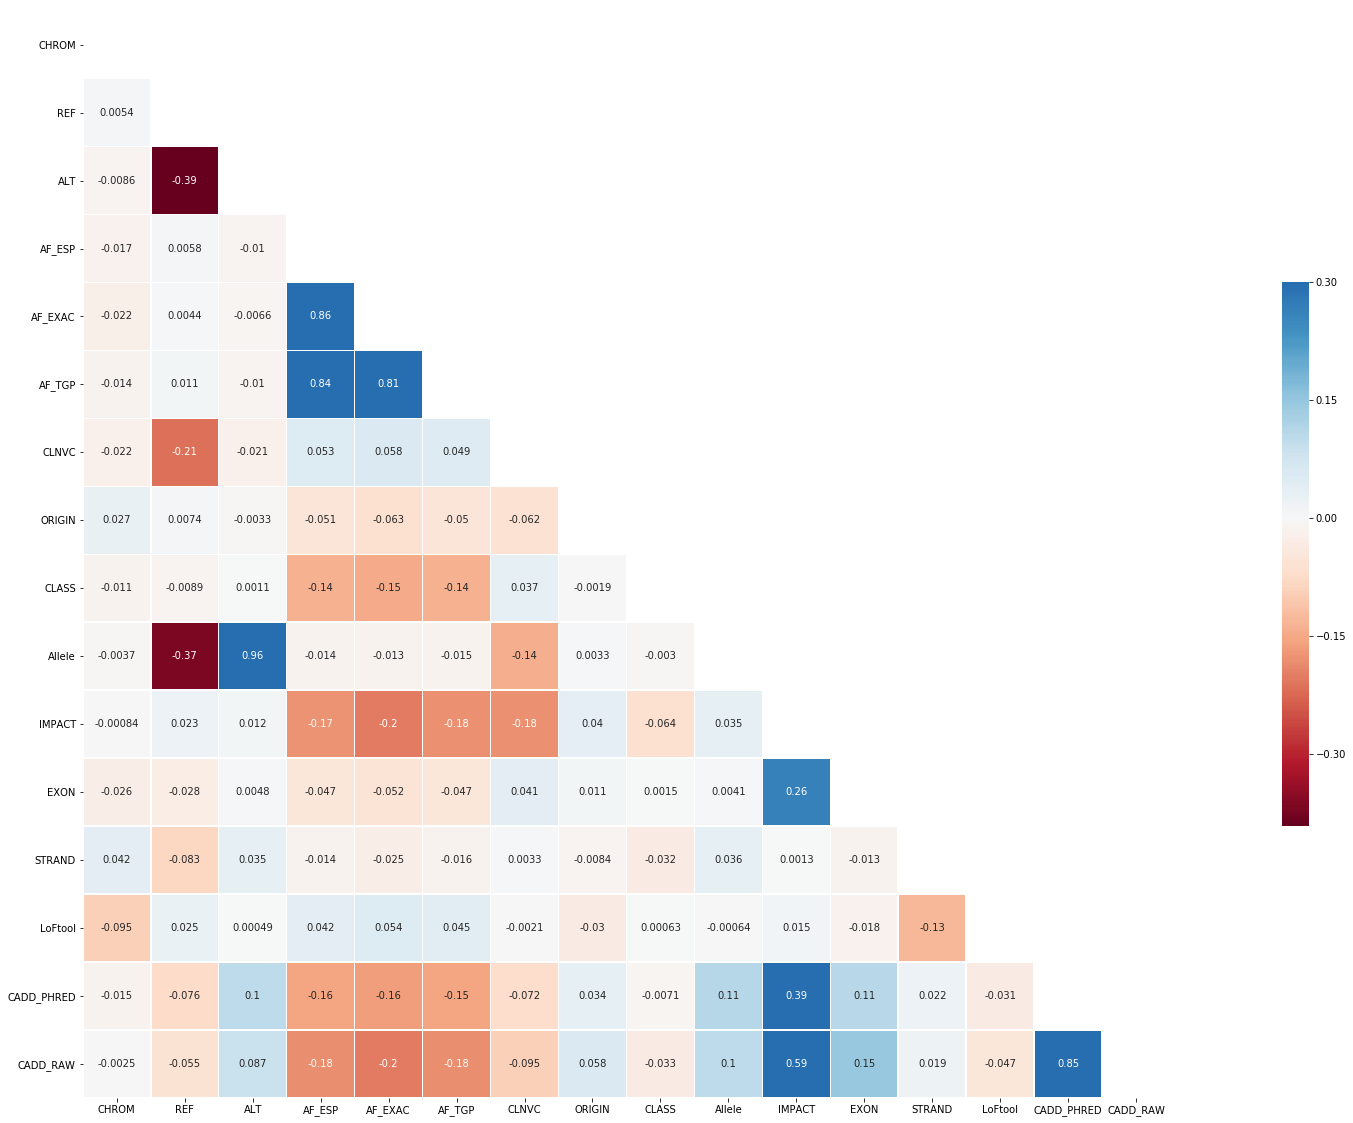

In [46]:
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(40,20))    
sns.heatmap(corr, mask=mask, cmap=plt.cm.RdBu, vmax=.3, center=0,annot=True,square=True,linewidths=.5, cbar_kws={"shrink": .5})

In [47]:
df.shape

(65188, 16)

In [48]:
df['REF'].unique()

array([2, 1, 0, 4, 3])

In [49]:
df.head()

CHROM  REF  ALT  AF_ESP  AF_EXAC  AF_TGP  CLNVC  ORIGIN  CLASS  Allele  \
0      0    2    1       0        0       0      3       1      0       1   
1      0    2    4       0     6308    1389      3       1      0       4   
2      0    2    1       0     2486      62      3       1      1       1   
3      0    1    4     318     1783     219      3       1      0       4   
4      0    1    4       0       22       7      3       1      1       4   

   IMPACT  EXON  STRAND  LoFtool  CADD_PHRED  CADD_RAW  
0       2    39       1      771        8316     25346  
1       1    39       1      771        6526     17951  
2       2    39       1      771        2730     10387  
3       1    92       1      771        8433     28385  
4       1   193       1      771        8952     37646

In [72]:
df.shape

(65188, 16)

In [75]:
df.head(1)

CHROM  REF  ALT  AF_ESP  AF_EXAC  AF_TGP  CLNVC  ORIGIN  CLASS  Allele  \
0      0    2    1       0        0       0      3       1      0       1   

   IMPACT  EXON  STRAND  LoFtool  CADD_PHRED  CADD_RAW  
0       2    39       1      771        8316     25346

In [ ]:
#df.to_csv('final_data.csv',index=False)

# Model Building

### Check for data imbalance
#### Conclusion: Data is highly imabalnced

In [50]:
df['CLASS'].value_counts(normalize=True) * 100

0    74.789839
1    25.210161
Name: CLASS, dtype: float64

### Split data

In [51]:
X = df.drop('CLASS',axis=1)
y = df['CLASS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y,shuffle=True)

### Over-Sampling using AdaSyn 

In [52]:
equalizer = ADASYN(random_state=42)
x_resampled, y_resampled = equalizer.fit_sample(X_train, y_train)

print('Normal Data: ', Counter(y_train))
print('Resampled: ', Counter(y_resampled))

Normal Data:  Counter({0: 34127, 1: 11504})
Resampled:  Counter({1: 34510, 0: 34127})


### Data Scaling 

In [53]:
scaler = MinMaxScaler(feature_range=(0, 1))
x_resampled = scaler.fit_transform(x_resampled)
X_test = scaler.transform(X_test)

###  Model train and check for best classifier

In [54]:
%%time
models = []
seed = 3

models.append(("LogReg",LogisticRegression()))
models.append(("SVC", SVC()))
#models.append(("XGBClassifier",XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("RandomForestClassifier",RandomForestClassifier()))
models.append(("RidgeClassifier",RidgeClassifier()))
models.append(("ExtraTreesClassifier",ExtraTreeClassifier()))

scoring = 'accuracy'
n_folds = 10
msgs = []
results, names  = [], [] 
print("Accuracies:")

for name, model  in models:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, x_resampled, y_resampled,cv=kfold, scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = "%s: %f" % (name, round(cv_results.mean(),2))
    msgs.append(msg)
    print(msg)

Accuracies:


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LogReg: 0.620000
SVC: 0.660000
KNN: 0.700000
DecisionTreeClassifier: 0.730000
RandomForestClassifier: 0.810000
RidgeClassifier: 0.610000
ExtraTreesClassifier: 0.710000
CPU times: user 414 ms, sys: 116 ms, total: 531 ms
Wall time: 13min 18s


### Conclusion: Base classifier "RandomForest" can be selected for further model training and improvement.

# Model Tuning

In [ ]:
%%time
rf_clf = RandomForestClassifier(random_state = seed)
param_grid = {"n_estimators": [100,150,200,250,300],
              "max_depth": [2,3,5,8],
              "min_samples_split": [15,20],
              "min_samples_leaf": [5,10,20],
              "max_leaf_nodes": [20,40]}

CV_log_rf = GridSearchCV(estimator = rf_clf, param_grid = param_grid , scoring = 'accuracy', verbose = 1, n_jobs = -1)
CV_log_rf.fit(x_resampled, y_resampled)

best_parameters = CV_log_rf.best_params_
print('Best parameters: ', best_parameters)

In [71]:
print("Best Score: ",CV_log_rf.best_score_)

Best Score:  0.7317118167112303


# Fit the tuned model

In [56]:
model = RandomForestClassifier(random_state=seed)

# feeding the training set into the model
model.fit(x_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

# Model Persistence

In [65]:
import joblib

In [63]:
joblib.dump(model, 'genetic_model.pkl')

['genetic_model.pkl']

# Prediction on Test

In [66]:
model_from_joblib = joblib.load('genetic_model.pkl')  

In [76]:
y_pred = model_from_joblib.predict(X_train)

In [77]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [79]:
X_train.head(1)

CHROM  REF  ALT  AF_ESP  AF_EXAC  AF_TGP  CLNVC  ORIGIN  Allele  \
59088     18    1    4      76     2097      98      3       1       4   

       IMPACT  EXON  STRAND  LoFtool  CADD_PHRED  CADD_RAW  
59088       1  1625       1     1113        8562     31347

In [67]:
y_pred = model_from_joblib.predict(X_test)

# predict probabilities
ns_probs = [0 for _ in range(len(y_test))]
rf_probs = model_from_joblib.predict_proba(X_test)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate scores
rf_probs = roc_auc_score(y_test, rf_probs)

# Model Performance
- Training Accuracy
- Testing Accuracy
- ROC_AUC
- Confusion Matrix
- Classification Report

In [68]:
print("Training accuracy: %.2f" %model_from_joblib.score(x_resampled, y_resampled))
print("Testing accuarcy: %.2f" %model_from_joblib.score(X_test, y_test))
print('ROC AUC: %.3f' % (rf_probs))

Training accuracy: 1.00
Testing accuarcy: 0.74
ROC AUC: 0.753


#### Confusion Matrix 

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

#### Classification Report

In [69]:
cls = classification_report(y_test, y_pred)
print(cls)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     14627
           1       0.48      0.51      0.49      4930

    accuracy                           0.74     19557
   macro avg       0.65      0.66      0.66     19557
weighted avg       0.74      0.74      0.74     19557



# END